Ce notebook vient de https://www.youtube.com/watch?v=NJNvXEYa_gM

Nous le modifions afin d'accéder à nos volumes ct scan et en extraire des slides en .png

Ce notebook est sauvegardé sur le github, mais les données auxquelles il accèdera devront être stockées sur notre machine.

Je (Samuel) conseille d'ouvrir le projet avec Vscode, et d'installer les extensions Jupyter pour exécuter ce notebook. 

In [4]:
pip install nibabel numpy opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 12.3 MB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
# CONSTANTES RELATIVES A CHAQUE MACHINE

# STEP 1 - Load and visualize data
dataInputPath = '~/pp2/data/volumes/'
imagePathInput = os.path.join(dataInputPath, 'img/')
maskPathInput = os.path.join(dataInputPath, 'mask/')

dataOutputPath = '~/pp2/data/slices/'
imageSliceOutput = os.path.join(dataOutputPath, 'img/')
maskSliceOutput = os.path.join(dataOutputPath, 'mask/')

# STEP 2 - Image normalization
HOUNSFIELD_MIN = -1000
HOUNSFIELD_MAX = 2000
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

# STEP 3 - Slicing and saving
SLICE_X = True
SLICE_Y = True
SLICE_Z = False

SLICE_DECIMATE_IDENTIFIER = 3

In [ ]:
# Premier tests :

nib.load()


In [4]:
# Load image and see max min Hounsfield units
imgPath = os.path.join(imagePathInput, 'tooth1.nii')
img = nib.load(imgPath).get_fdata()
np.min(img), np.max(img), img.shape, type(img)

(-933.0, 2070.0, (45, 45, 90), numpy.memmap)

In [5]:
# Load image mask and see max min Hounsfield units
maskPath = os.path.join(maskPathInput, 'tooth1.nii')
mask = nib.load(maskPath).get_fdata()
np.min(mask), np.max(mask), mask.shape, type(mask)

(0.0, 1.0, (45, 45, 90), numpy.memmap)

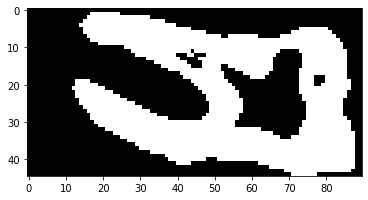

In [6]:
# Show image slice
imgSlice = mask[20,:,:]
plt.imshow(imgSlice, cmap='gray')
plt.show()

In [7]:
# Normalize image
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

nImg = normalizeImageIntensityRange(img)
np.min(nImg), np.max(nImg), nImg.shape, type(nImg)

(0.022333333333333334, 1.0, (45, 45, 90), numpy.ndarray)

In [8]:
# Read image or mask volume
def readImageVolume(imgPath, normalize=False):
    img = nib.load(imgPath).get_fdata()
    if normalize:
        return normalizeImageIntensityRange(img)
    else:
        return img
    
readImageVolume(imgPath, normalize=True)
readImageVolume(maskPath, normalize=False)

memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [9]:
# Save volume slice to file
def saveSlice(img, fname, path):
    img = np.uint8(img * 255)
    fout = os.path.join(path, f'{fname}.png')
    cv2.imwrite(fout, img)
    print(f'[+] Slice saved: {fout}', end='\r')
    
saveSlice(nImg[20,:,:], 'test', imageSliceOutput)
saveSlice(mask[20,:,:], 'test', maskSliceOutput)

[+] Slice saved: data/slices/img/test.png


In [10]:
# Slice image in all directions and save
def sliceAndSaveVolumeImage(vol, fname, path):
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    cnt = 0
    if SLICE_X:
        cnt += dimx
        print('Slicing X: ')
        for i in range(dimx):
            saveSlice(vol[i,:,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', path)
            
    if SLICE_Y:
        cnt += dimy
        print('Slicing Y: ')
        for i in range(dimy):
            saveSlice(vol[:,i,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', path)
            
    if SLICE_Z:
        cnt += dimz
        print('Slicing Z: ')
        for i in range(dimz):
            saveSlice(vol[:,:,i], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path)
    return cnt

In [11]:
# Read and process image volumes
for index, filename in enumerate(sorted(glob.iglob(imagePathInput+'*.nii'))):
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'tooth'+str(index), imageSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

data/volumes/img/tooth1.nii (45, 45, 90) 180 0.022333333333333334 1.0
Slicing X: 
[+] Slice saved: data/slices/img/tooth0-slice000_x.png
[+] Slice saved: data/slices/img/tooth0-slice001_x.png
[+] Slice saved: data/slices/img/tooth0-slice002_x.png
[+] Slice saved: data/slices/img/tooth0-slice003_x.png
[+] Slice saved: data/slices/img/tooth0-slice004_x.png
[+] Slice saved: data/slices/img/tooth0-slice005_x.png
[+] Slice saved: data/slices/img/tooth0-slice006_x.png
[+] Slice saved: data/slices/img/tooth0-slice007_x.png
[+] Slice saved: data/slices/img/tooth0-slice008_x.png
[+] Slice saved: data/slices/img/tooth0-slice009_x.png
[+] Slice saved: data/slices/img/tooth0-slice010_x.png
[+] Slice saved: data/slices/img/tooth0-slice011_x.png
[+] Slice saved: data/slices/img/tooth0-slice012_x.png
[+] Slice saved: data/slices/img/tooth0-slice013_x.png
[+] Slice saved: data/slices/img/tooth0-slice014_x.png
[+] Slice saved: data/slices/img/tooth0-slice015_x.png
[+] Slice saved: data/slices/img/tooth

data/volumes/img/tooth3.nii (46, 46, 92) 184 0.0 0.9866666666666667
Slicing X: 
[+] Slice saved: data/slices/img/tooth2-slice000_x.png
[+] Slice saved: data/slices/img/tooth2-slice001_x.png
[+] Slice saved: data/slices/img/tooth2-slice002_x.png
[+] Slice saved: data/slices/img/tooth2-slice003_x.png
[+] Slice saved: data/slices/img/tooth2-slice004_x.png
[+] Slice saved: data/slices/img/tooth2-slice005_x.png
[+] Slice saved: data/slices/img/tooth2-slice006_x.png
[+] Slice saved: data/slices/img/tooth2-slice007_x.png
[+] Slice saved: data/slices/img/tooth2-slice008_x.png
[+] Slice saved: data/slices/img/tooth2-slice009_x.png
[+] Slice saved: data/slices/img/tooth2-slice010_x.png
[+] Slice saved: data/slices/img/tooth2-slice011_x.png
[+] Slice saved: data/slices/img/tooth2-slice012_x.png
[+] Slice saved: data/slices/img/tooth2-slice013_x.png
[+] Slice saved: data/slices/img/tooth2-slice014_x.png
[+] Slice saved: data/slices/img/tooth2-slice015_x.png
[+] Slice saved: data/slices/img/tooth2-

In [12]:
# Read and process image mask volumes
for index, filename in enumerate(sorted(glob.iglob(maskPathInput+'*.nii'))):
    img = readImageVolume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'tooth'+str(index), maskSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

data/volumes/mask/tooth1.nii (45, 45, 90) 180 0.0 1.0
Slicing X: 
Slicing Y: aved: data/slices/mask/tooth0-slice044_x.png
[+] Slice saved: data/slices/mask/tooth0-slice044_y.png
data/volumes/mask/tooth1.nii, 90 slices created 

data/volumes/mask/tooth2.nii (45, 45, 90) 180 0.0 1.0
Slicing X: 
Slicing Y: aved: data/slices/mask/tooth1-slice044_x.png
[+] Slice saved: data/slices/mask/tooth1-slice044_y.png
data/volumes/mask/tooth2.nii, 90 slices created 

data/volumes/mask/tooth3.nii (46, 46, 92) 184 0.0 1.0
Slicing X: 
Slicing Y: aved: data/slices/mask/tooth2-slice045_x.png
[+] Slice saved: data/slices/mask/tooth2-slice045_y.png
data/volumes/mask/tooth3.nii, 92 slices created 

data/volumes/mask/tooth4.nii (44, 44, 88) 176 0.0 1.0
Slicing X: 
Slicing Y: aved: data/slices/mask/tooth3-slice043_x.png
[+] Slice saved: data/slices/mask/tooth3-slice043_y.png
data/volumes/mask/tooth4.nii, 88 slices created 

data/volumes/mask/tooth5.nii (50, 50, 100) 200 0.0 1.0
Slicing X: 
Slicing Y: aved: data

In [13]:
# https://github.com/madsendennis/notebooks